In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import json
import os
import re
from copy import deepcopy
import sys
from typing import List, Dict, Tuple, Union, Optional, Any
import torch
from tqdm import tqdm
from collections import defaultdict
from IPython.display import display

mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 12
COLORSCHEME = np.array(
    ["#82B0D2", "#FA7F6F", "#8EEFD9", "#BEB8DC", "#FFBE7A", "#E7DAD2", "#999999"]
)

In [14]:
# constants
DATASET_NAMES = [
    "glue-cola",
    "glue-mnli",
    "glue-mrpc",
    "glue-qqp",
    "glue-rte",
    "glue-sst2",
    "glue-stsb",
]
MODEL_NAME = "flan-t5-base"

## Load Data

### Max score for single task

In [15]:
def zero_if_nan(x):
    """
    Returns 0 if the input is NaN, otherwise returns the input.

    Args:
        x (float): The input value.

    Returns:
        float: The input value, or 0 if the input is NaN.
    """
    if np.isnan(x):
        return 0
    else:
        return x


def version_of_max_accuracy(
    model_name: str,
    single_task_data: pd.DataFrame,
    dataset_name: str,
    method: str,
) -> str:
    """
    Given a model name, a dataset name, and a DataFrame containing single task data,
    returns the version of the model with the highest accuracy on the given dataset.

    Args:
        model_name (str): the name of the model to search for
        single_task_data (pd.DataFrame): a DataFrame containing single task data
        dataset_name (str): the name of the dataset to search for

    Returns:
        version (str): the version of the model with the highest accuracy on the given dataset
    """

    seleted_rows = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["model"] == model_name,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == method,
            )
        ]
    ]
    max_row = seleted_rows.loc[seleted_rows["accuracy"].idxmax()]
    version = max_row["version"]
    return version

In [25]:
single_task_data = pd.read_csv("single_task.csv")

# max_score { finetune_mode: {dataset_name: float }}
max_score = {"finetune_mode": [], "task": [], "score": []}

for dataset_name in DATASET_NAMES:
    # get the version of the model with the highest accuracy on the given dataset
    version = version_of_max_accuracy(
        MODEL_NAME, single_task_data, dataset_name, method="fullfinetuned"
    )
    row = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["version"] == version,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == "fullfinetuned",
            )
        ]
    ]
    assert len(row) == 1
    max_score["finetune_mode"].append("standard")
    max_score["task"].append(dataset_name)
    max_score["score"].append(row.iloc[0]["accuracy"])

for dataset_name in DATASET_NAMES:
    # get the version of the model with the highest accuracy on the given dataset
    version = version_of_max_accuracy(
        MODEL_NAME,
        single_task_data[single_task_data["LoRA.r"] == 16],
        dataset_name,
        method="lora",
    )
    row = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["version"] == version,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == "lora",
            )
        ]
    ]
    assert len(row) == 1
    max_score["finetune_mode"].append("lora")
    max_score["task"].append(dataset_name)
    max_score["score"].append(row.iloc[0]["accuracy"])

for dataset_name in DATASET_NAMES:
    # get the version of the model with the highest accuracy on the given dataset
    version = version_of_max_accuracy(
        MODEL_NAME,
        single_task_data[single_task_data["LoRA.r"] == 16],
        dataset_name,
        method="l_lora",
    )
    row = single_task_data[
        [
            all(b)
            for b in zip(
                single_task_data["version"] == version,
                single_task_data["dataset"] == dataset_name,
                single_task_data["method"] == "l_lora",
            )
        ]
    ]
    assert len(row) == 1
    max_score["finetune_mode"].append("l_lora")
    max_score["task"].append(dataset_name)
    max_score["score"].append(row.iloc[0]["accuracy"])

max_score = pd.DataFrame(max_score)
max_score

,finetune_mode,task,score
0,standard,glue-cola,0.752637
1,standard,glue-mnli,0.824147
2,standard,glue-mrpc,0.857843
3,standard,glue-qqp,0.836087
4,standard,glue-rte,0.851986
5,standard,glue-sst2,0.933486
6,standard,glue-stsb,0.904585
7,lora,glue-cola,0.692234
8,lora,glue-mnli,0.761386
9,lora,glue-mrpc,0.803922


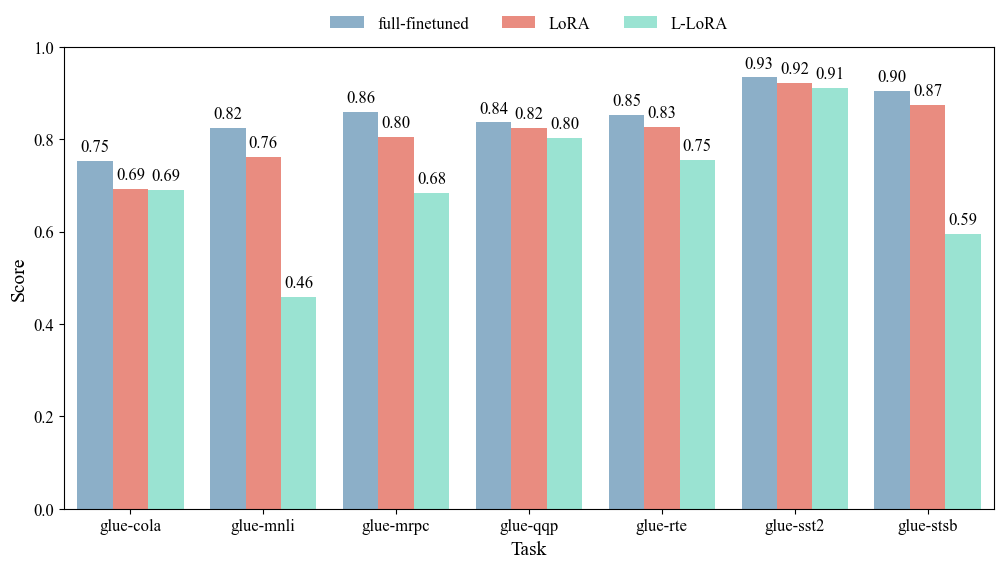

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(
    ax=ax,
    data=max_score,
    x="task",
    y="score",
    hue="finetune_mode",
    palette=COLORSCHEME,
)

# add value labels
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

# adjust legend
h, labels = ax.get_legend_handles_labels()
ax.legend(h, ["full-finetuned", "LoRA", "L-LoRA"])
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    title=None,
    frameon=False,
)

# adjust axis
ax.set_ylim(0, 1)
ax.set_xlabel("Task", fontsize=14)
ax.set_ylabel("Score", fontsize=14)

plt.show()

### Load Raw Data

In [229]:
# raw_data = { method: { finetune_mode: { num_tasks: pd.DataFrame }}}
raw_data = {}

# --- Load data ---
# load simple average data
raw_data["simple_average"] = {}
raw_data["simple_average"]["standard"] = {}
for num_tasks in range(2, 8):
    raw_data["simple_average"]["standard"][num_tasks] = pd.read_csv(
        f"fft_average_num-tasks={num_tasks}.csv"
    )
raw_data["simple_average"]["lora"] = {}
for num_tasks in range(2, 8):
    raw_data["simple_average"]["lora"][num_tasks] = pd.read_csv(
        f"lora_average_num-tasks={num_tasks}.csv"
    )
raw_data["simple_average"]["l_lora"] = {}
for num_tasks in range(2, 8):
    raw_data["simple_average"]["l_lora"][num_tasks] = pd.read_csv(
        f"l_lora_average_num-tasks={num_tasks}.csv"
    )

# load task arithmetic data
raw_data["task_arithmetic"] = {}
raw_data["task_arithmetic"]["standard"] = {}
for num_tasks in range(2, 8):
    raw_data["task_arithmetic"]["standard"][num_tasks] = pd.read_csv(
        f"fft_task_addition_num-tasks={num_tasks}.csv"
    )
raw_data["task_arithmetic"]["lora"] = {}
for num_tasks in range(2, 8):
    raw_data["task_arithmetic"]["lora"][num_tasks] = pd.read_csv(
        f"lora_task_addition_num-tasks={num_tasks}.csv"
    )
raw_data["task_arithmetic"]["l_lora"] = {}
for num_tasks in range(2, 8):
    raw_data["task_arithmetic"]["l_lora"][num_tasks] = pd.read_csv(
        f"l_lora_task_addition_num-tasks={num_tasks}.csv"
    )

# load ties merging data
raw_data["ties_merging"] = {}
raw_data["ties_merging"]["standard"] = {}
for num_tasks in range(2, 8):
    raw_data["ties_merging"]["standard"][num_tasks] = pd.read_csv(
        f"fft_ties_merging_num-tasks={num_tasks}.csv"
    )
raw_data["ties_merging"]["lora"] = {}
for num_tasks in range(2, 8):
    raw_data["ties_merging"]["lora"][num_tasks] = pd.read_csv(
        f"lora_ties_merging_num-tasks={num_tasks}.csv"
    )
raw_data["ties_merging"]["l_lora"] = {}
for num_tasks in range(2, 8):
    raw_data["ties_merging"]["l_lora"][num_tasks] = pd.read_csv(
        f"l_lora_ties_merging_num-tasks={num_tasks}.csv"
    )

# load lorahub data
raw_data["lorahub"] = {}
raw_data["lorahub"]["lora"] = {}
for num_tasks in range(2, 8):
    raw_data["lorahub"]["lora"][num_tasks] = pd.read_csv(
        f"lora_lorahub_num-tasks={num_tasks}.csv"
    )
raw_data["lorahub"]["l_lora"] = {}
for num_tasks in range(2, 8):
    raw_data["lorahub"]["l_lora"][num_tasks] = pd.read_csv(
        f"l_lora_lorahub_num-tasks={num_tasks}.csv"
    )

# load tangent_proj data
raw_data["tangent_proj"] = {}
raw_data["tangent_proj"]["standard"] = {}
for num_tasks in range(2, 8):
    raw_data["tangent_proj"]["standard"][num_tasks] = pd.read_csv(
        f"fft_tangent_project_num-tasks={num_tasks}.csv"
    )
raw_data["tangent_proj"]["lora"] = {}
for num_tasks in range(2, 8):
    raw_data["tangent_proj"]["lora"][num_tasks] = pd.read_csv(
        f"lora_tangent_project_num-tasks={num_tasks}.csv"
    )
raw_data["tangent_proj"]["l_lora"] = {}
for num_tasks in range(2, 8):
    raw_data["tangent_proj"]["l_lora"][num_tasks] = pd.read_csv(
        f"l_lora_tangent_project_num-tasks={num_tasks}.csv"
    )

In [230]:
relative_raw_data = deepcopy(raw_data)
for method in relative_raw_data:
    for finetune_mode in relative_raw_data[method]:
        print("processing method", method, "finetune_mode", finetune_mode)
        for num_tasks in tqdm(relative_raw_data[method][finetune_mode]):
            df = relative_raw_data[method][finetune_mode][num_tasks]
            for raw_id in range(len(df)):
                for dataset_name in DATASET_NAMES:
                    score = (
                        df.at[raw_id, dataset_name]
                        / max_score[
                            (max_score["finetune_mode"] == finetune_mode)
                            & (max_score["task"] == dataset_name)
                        ]["score"].values
                    )
                    assert len(score) == 1, f"len(score) = {len(score)}"
                    score = score[0]
                    df.at[raw_id, dataset_name] = score
            relative_raw_data[method][finetune_mode][num_tasks] = df

processing method simple_average finetune_mode standard


100%|██████████| 6/6 [00:00<00:00, 17.05it/s]


processing method simple_average finetune_mode lora


100%|██████████| 6/6 [00:00<00:00, 18.12it/s]


processing method simple_average finetune_mode l_lora


100%|██████████| 6/6 [00:00<00:00, 18.17it/s]


processing method task_arithmetic finetune_mode standard


100%|██████████| 6/6 [00:06<00:00,  1.15s/it]


processing method task_arithmetic finetune_mode lora


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


processing method task_arithmetic finetune_mode l_lora


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


processing method ties_merging finetune_mode standard


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


processing method ties_merging finetune_mode lora


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


processing method ties_merging finetune_mode l_lora


100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


processing method lorahub finetune_mode lora


100%|██████████| 6/6 [00:00<00:00, 17.96it/s]


processing method lorahub finetune_mode l_lora


100%|██████████| 6/6 [00:00<00:00, 17.99it/s]


processing method tangent_proj finetune_mode standard


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]


processing method tangent_proj finetune_mode lora


100%|██████████| 6/6 [00:00<00:00, 17.85it/s]


processing method tangent_proj finetune_mode l_lora


100%|██████████| 6/6 [00:00<00:00, 17.88it/s]


### Process Data

In [231]:
def get_row_mean(
    row,
    col_names: List[str] = DATASET_NAMES,
):
    """
    Returns the mean value for a subset of columns in a pandas Series.

    Args:
        row (pd.Series): The input row of a pandas DataFrame.
        col_names (List[str], optional): A list of column names to include in the mean calculation. Defaults to ["glue-cola", "glue-mnli", "glue-mrpc", "glue-qqp", "glue-rte", "glue-sst2", "glue-stsb"].

    Returns:
        float: The mean value for the specified columns in the input row.
    """
    zero_if_nan = lambda x: 0 if np.isnan(x) else x
    s = 0
    for col in col_names:
        s += zero_if_nan(row[col])
    return s / len(col_names)


def get_row_std(
    row,
    col_names: List[str] = DATASET_NAMES,
):
    x = []
    for col in col_names:
        x.append(zero_if_nan(row[col]))
    return np.std(x)


def append_mean_col(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a new DataFrame with an additional column called "mean" that contains the mean value for each row.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with an additional column called "mean".
    """
    df = deepcopy(df)
    df["mean"] = df.apply(get_row_mean, axis=1)
    return df


def get_max_row_mean(data: Dict[int, pd.DataFrame]) -> Dict[int, pd.DataFrame]:
    """
    Computes the row with the highest mean for each group of tasks and datasets in the input data.

    Args:
        data (dict): A dictionary of pandas DataFrames where each key represents the number of tasks in the dataset.

    Returns:
        dict: A dictionary of pandas DataFrames where each DataFrame contains the row with the highest mean for each group of tasks and datasets.
    """
    results = defaultdict(lambda: list())
    for num_tasks in data.keys():
        group = data[num_tasks].groupby([f"dataset:{i}" for i in range(num_tasks)])
        for g in group:
            tasks = g[0]
            max_mean = float("-inf")
            max_index = 0
            for i, row in g[1].iterrows():
                mean = get_row_mean(row)
                if mean > max_mean:
                    max_mean = mean
                    max_index = i
            row = deepcopy(data[num_tasks].iloc[max_index])
            row.loc["mean"] = max_mean
            results[num_tasks].append(row)
        results[num_tasks] = pd.DataFrame(results[num_tasks])
    return dict(results)

In [240]:
def process_data(raw_data):
    processed_data = {}

    # process simple average data
    processed_data["simple_average"] = {}
    processed_data["simple_average"]["standard"] = {}
    for num_tasks in raw_data["simple_average"]["standard"]:
        processed_data["simple_average"]["standard"][num_tasks] = append_mean_col(
            raw_data["simple_average"]["standard"][num_tasks]
        )
    processed_data["simple_average"]["lora"] = {}
    for num_tasks in raw_data["simple_average"]["lora"]:
        processed_data["simple_average"]["lora"][num_tasks] = append_mean_col(
            raw_data["simple_average"]["lora"][num_tasks]
        )
    processed_data["simple_average"]["l_lora"] = {}
    for num_tasks in raw_data["simple_average"]["l_lora"]:
        processed_data["simple_average"]["l_lora"][num_tasks] = append_mean_col(
            raw_data["simple_average"]["l_lora"][num_tasks]
        )

    # process task arithmetic data
    processed_data["task_arithmetic"] = {}
    processed_data["task_arithmetic"]["standard"] = {}
    processed_data["task_arithmetic"]["standard"] = get_max_row_mean(
        raw_data["task_arithmetic"]["standard"]
    )
    processed_data["task_arithmetic"]["lora"] = {}
    processed_data["task_arithmetic"]["lora"] = get_max_row_mean(
        raw_data["task_arithmetic"]["lora"]
    )
    processed_data["task_arithmetic"]["l_lora"] = {}
    processed_data["task_arithmetic"]["l_lora"] = get_max_row_mean(
        raw_data["task_arithmetic"]["l_lora"]
    )

    # process ties merging data
    processed_data["ties_merging"] = {}
    processed_data["ties_merging"]["standard"] = {}
    processed_data["ties_merging"]["standard"] = get_max_row_mean(
        raw_data["ties_merging"]["standard"]
    )
    processed_data["ties_merging"]["lora"] = {}
    processed_data["ties_merging"]["lora"] = get_max_row_mean(
        raw_data["ties_merging"]["lora"]
    )
    processed_data["ties_merging"]["l_lora"] = {}
    processed_data["ties_merging"]["l_lora"] = get_max_row_mean(
        raw_data["ties_merging"]["l_lora"]
    )

    # process lorahub data
    processed_data["lorahub"] = {}
    processed_data["lorahub"]["lora"] = {}
    for num_tasks in raw_data["lorahub"]["lora"]:
        processed_data["lorahub"]["lora"][num_tasks] = append_mean_col(
            raw_data["lorahub"]["lora"][num_tasks]
        )
    processed_data["lorahub"]["l_lora"] = {}
    for num_tasks in raw_data["lorahub"]["l_lora"]:
        processed_data["lorahub"]["l_lora"][num_tasks] = append_mean_col(
            raw_data["lorahub"]["l_lora"][num_tasks]
        )

    # process tangent_proj data
    processed_data["tangent_proj"] = {}
    processed_data["tangent_proj"]["standard"] = {}
    for num_tasks in raw_data["tangent_proj"]["standard"]:
        processed_data["tangent_proj"]["standard"][num_tasks] = append_mean_col(
            raw_data["tangent_proj"]["standard"][num_tasks]
        )
    processed_data["tangent_proj"]["lora"] = {}
    for num_tasks in raw_data["tangent_proj"]["lora"]:
        processed_data["tangent_proj"]["lora"][num_tasks] = append_mean_col(
            raw_data["tangent_proj"]["lora"][num_tasks]
        )
    processed_data["tangent_proj"]["l_lora"] = {}
    for num_tasks in raw_data["tangent_proj"]["l_lora"]:
        processed_data["tangent_proj"]["l_lora"][num_tasks] = append_mean_col(
            raw_data["tangent_proj"]["l_lora"][num_tasks]
        )

    # convert all nan in pprocessed_data to 0
    for method in processed_data:
        for finetune_mode in processed_data[method]:
            for num_tasks in processed_data[method][finetune_mode]:
                processed_data[method][finetune_mode][num_tasks] = processed_data[
                    method
                ][finetune_mode][num_tasks].fillna(0)

    return processed_data

In [241]:
processed_data = process_data(raw_data)

In [242]:
relative_processed_data = process_data(relative_raw_data)

# Plot Results

In [243]:
def plot_scores_by_finetune_mode(plot_data):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, squeeze=False)

    ax: plt.Axes = axes[0, 0]
    ax.set_title("full-finetuned")
    ax.set_xlabel("Number of Tasks")
    ax.set_ylabel("Score")
    ax: plt.Axes = axes[0, 1]
    ax.set_title("LoRA")
    ax.set_xlabel("Number of Tasks")
    ax: plt.Axes = axes[0, 2]
    ax.set_title("L-LoRA")
    ax.set_xlabel("Number of Tasks")

    for method_id, method in enumerate(plot_data):
        for finetune_mode_id, finetune_mode in enumerate(['standard', 'lora', 'l_lora']):
            if finetune_mode not in plot_data[method]:
                continue
            ax :plt.Axes = axes[0, finetune_mode_id]
            X, Y_MEAN, Y_STD = [], [], []
            for num_tasks in plot_data[method][finetune_mode]:
                X.append(num_tasks)
                y_at_x: pd.Series = plot_data[method][finetune_mode][num_tasks]["mean"]
                Y_MEAN.append(y_at_x.mean())
                Y_STD.append(zero_if_nan(y_at_x.std()))
            ax.plot(X, Y_MEAN, label=method, color=COLORSCHEME[method_id])
            ax.fill_between(
                X,
                np.array(Y_MEAN) - np.array(Y_STD),
                np.array(Y_MEAN) + np.array(Y_STD),
                alpha=0.2,
                color=COLORSCHEME[method_id],
            )

    # plot legend
    ax: plt.Axes = axes[0, 1]
    h, labels = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=5)

    plt.show()

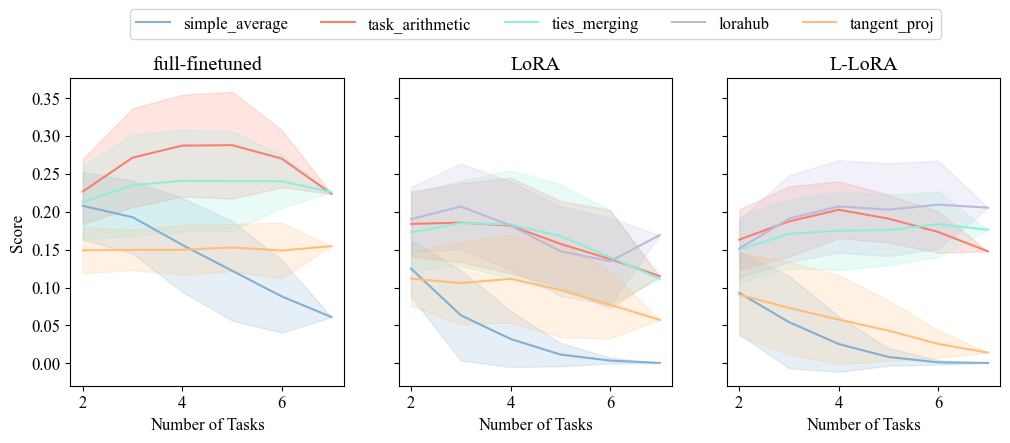

In [244]:
plot_scores_by_finetune_mode(processed_data)

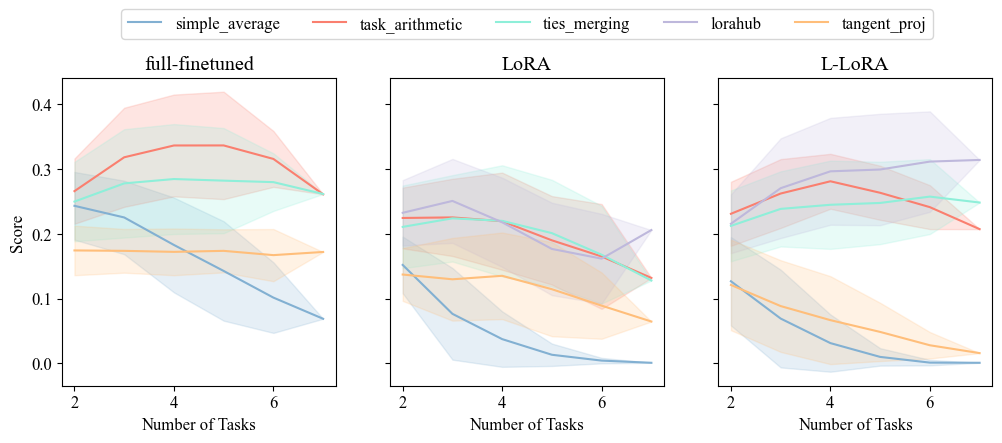

In [245]:
plot_scores_by_finetune_mode(relative_processed_data)

In [246]:
def plot_scores_by_finetune_mode_partial(plot_data):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True, squeeze=False)

    ax: plt.Axes = axes[0, 0]
    ax.set_title("full-finetuned")
    ax.set_xlabel("Number of Tasks")
    ax.set_ylabel("Score")
    ax: plt.Axes = axes[0, 1]
    ax.set_title("LoRA")
    ax.set_xlabel("Number of Tasks")
    ax: plt.Axes = axes[0, 2]
    ax.set_title("L-LoRA")
    ax.set_xlabel("Number of Tasks")

    for method_id, method in enumerate(plot_data):
        for finetune_mode_id, finetune_mode in enumerate(
            ["standard", "lora", "l_lora"]
        ):
            if finetune_mode not in plot_data[method]:
                continue
            ax: plt.Axes = axes[0, finetune_mode_id]
            X, Y_MEAN, Y_STD = [], [], []
            for num_tasks in plot_data[method][finetune_mode]:
                X.append(num_tasks)
                y_at_x = []
                df = plot_data[method][finetune_mode][num_tasks]
                for i in range(len(df)):
                    dataset_names = [
                        df.iloc[i][f"dataset:{j}"] for j in range(num_tasks)
                    ]
                    y_at_x.append(np.mean([df.iloc[i][d] for d in dataset_names]))
                y_at_x = np.array(y_at_x)
                Y_MEAN.append(y_at_x.mean())
                Y_STD.append(zero_if_nan(y_at_x.std()))
            ax.plot(X, Y_MEAN, label=method, color=COLORSCHEME[method_id])
            ax.fill_between(
                X,
                np.array(Y_MEAN) - np.array(Y_STD),
                np.array(Y_MEAN) + np.array(Y_STD),
                alpha=0.2,
                color=COLORSCHEME[method_id],
            )

    # plot legend
    ax: plt.Axes = axes[0, 1]
    h, labels = ax.get_legend_handles_labels()
    ax.legend(h, labels, loc="lower center", bbox_to_anchor=(0.5, 1.1), ncol=5)

    plt.show()

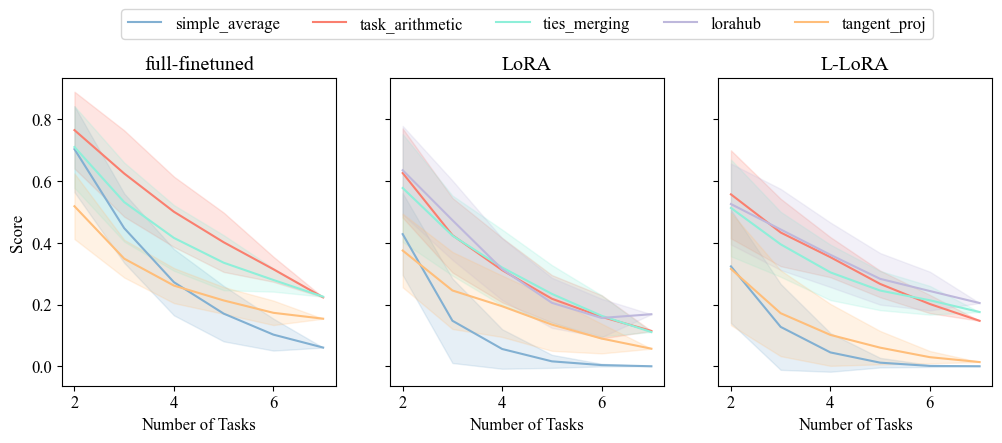

In [247]:
plot_scores_by_finetune_mode_partial(processed_data)

Plot Results for single method, different Finetune mode

In [248]:
def plot_scores_by_method(ax: plt.Axes, plot_data):
    finetune_mode_labels = {
        "standard": "full-finetune",
        "lora": "LoRA",
        "l_lora": "L-LoRA",
    }
    for finetune_mode_idx, finetune_mode in enumerate(["standard", "lora", "l_lora"]):
        if finetune_mode not in plot_data:
            continue
        X, Y_MEAN, Y_STD = [], [], []
        for num_tasks in plot_data[finetune_mode]:
            X.append(num_tasks)
            y_at_x: pd.Series = plot_data[finetune_mode][num_tasks]["mean"]
            Y_MEAN.append(y_at_x.mean())
            Y_STD.append(zero_if_nan(y_at_x.std()))
        ax.plot(
            X,
            Y_MEAN,
            label=finetune_mode_labels[finetune_mode],
            color=COLORSCHEME[finetune_mode_idx],
        )
        ax.fill_between(
            X,
            np.array(Y_MEAN) - np.array(Y_STD),
            np.array(Y_MEAN) + np.array(Y_STD),
            alpha=0.2,
            color=COLORSCHEME[finetune_mode_idx],
        )

    return ax

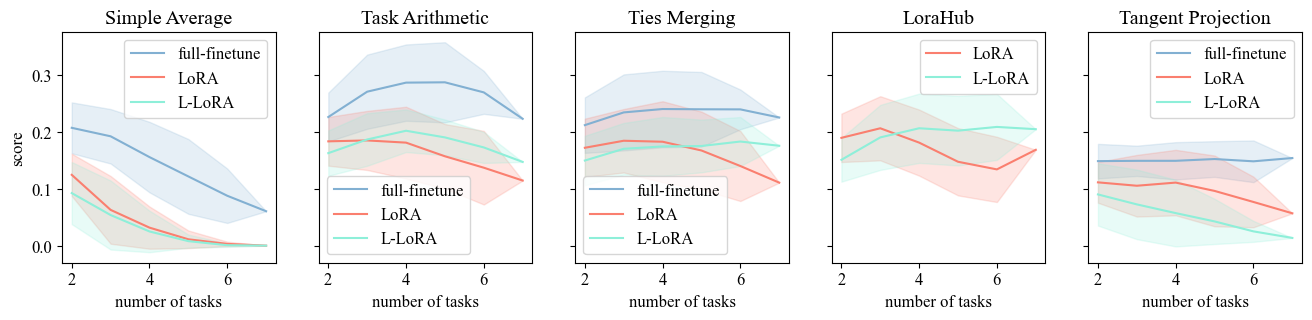

In [250]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharey=True, squeeze=False)
ax: plt.Axes = axes[0, 0]
plot_scores_by_method(ax, processed_data["simple_average"])
ax.legend()
ax.set_title("Simple Average")
ax.set_xlabel('number of tasks')
ax.set_ylabel('score')

ax: plt.Axes = axes[0, 1]
plot_scores_by_method(ax, processed_data["task_arithmetic"])
ax.legend()
ax.set_title("Task Arithmetic")
ax.set_xlabel('number of tasks')

ax: plt.Axes = axes[0, 2]
plot_scores_by_method(ax, processed_data["ties_merging"])
ax.legend()
ax.set_title("Ties Merging")
ax.set_xlabel('number of tasks')

ax: plt.Axes = axes[0, 3]
plot_scores_by_method(ax, processed_data["lorahub"])
ax.legend()
ax.set_title("LoraHub")
ax.set_xlabel('number of tasks')

ax: plt.Axes = axes[0,4]
plot_scores_by_method(ax, processed_data["tangent_proj"])
ax.legend()
ax.set_title("Tangent Projection")
ax.set_xlabel('number of tasks')

plt.show()

In [211]:
def plot_scores_by_method_partial(ax: plt.Axes, plot_data):
    finetune_mode_labels = {
        "standard": "full-finetune",
        "lora": "LoRA",
        "l_lora": "L-LoRA",
    }
    for finetune_mode_idx, finetune_mode in enumerate(["standard", "lora", "l_lora"]):
        if finetune_mode not in plot_data:
            continue
        X, Y_MEAN, Y_STD = [], [], []
        for num_tasks in plot_data[finetune_mode]:
            X.append(num_tasks)
            y_at_x = []
            df = plot_data[finetune_mode][num_tasks]
            for i in range(len(df)):
                dataset_names = [df.iloc[i][f'dataset:{j}'] for j in range(num_tasks)]
                y_at_x.append(np.mean([df.iloc[i][d] for d in dataset_names]))
            y_at_x = np.array(y_at_x)
            Y_MEAN.append(y_at_x.mean())
            Y_STD.append(zero_if_nan(y_at_x.std()))
        ax.plot(
            X,
            Y_MEAN,
            label=finetune_mode_labels[finetune_mode],
            color=COLORSCHEME[finetune_mode_idx],
        )
        ax.fill_between(
            X,
            np.array(Y_MEAN) - np.array(Y_STD),
            np.array(Y_MEAN) + np.array(Y_STD),
            alpha=0.2,
            color=COLORSCHEME[finetune_mode_idx],
        )

    return ax

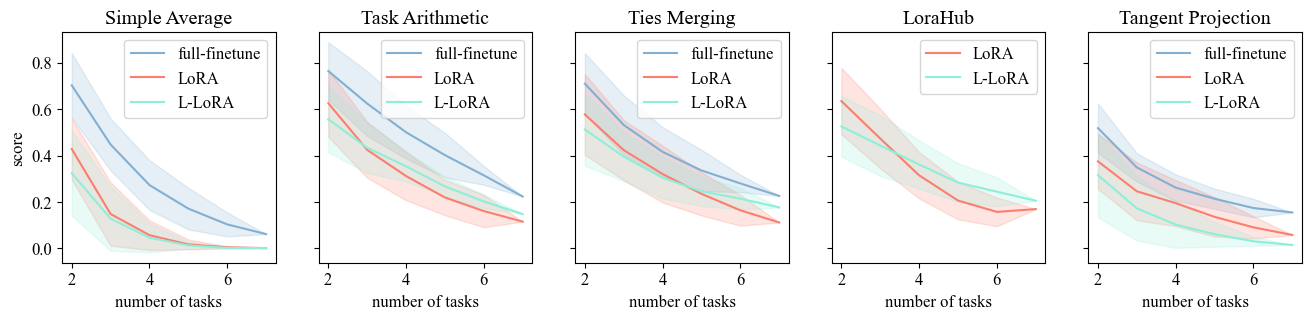

In [251]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3), sharey=True, squeeze=False)
ax: plt.Axes = axes[0, 0]
plot_scores_by_method_partial(ax, processed_data["simple_average"])
ax.legend()
ax.set_title("Simple Average")
ax.set_xlabel('number of tasks')
ax.set_ylabel('score')

ax: plt.Axes = axes[0, 1]
plot_scores_by_method_partial(ax, processed_data["task_arithmetic"])
ax.legend()
ax.set_title("Task Arithmetic")
ax.set_xlabel('number of tasks')

ax: plt.Axes = axes[0, 2]
plot_scores_by_method_partial(ax, processed_data["ties_merging"])
ax.legend()
ax.set_title("Ties Merging")
ax.set_xlabel('number of tasks')

ax: plt.Axes = axes[0, 3]
plot_scores_by_method_partial(ax, processed_data["lorahub"])
ax.legend()
ax.set_title("LoraHub")
ax.set_xlabel('number of tasks')

ax: plt.Axes = axes[0,4]
plot_scores_by_method_partial(ax, processed_data["tangent_proj"])
ax.legend()
ax.set_title("Tangent Projection")
ax.set_xlabel('number of tasks')

plt.show()

## Tabular Data

In [202]:

processed_data['simple_average']['standard'][4]

,dataset:0,dataset:1,dataset:2,dataset:3,glue-cola,glue-mnli,glue-mrpc,glue-qqp,glue-rte,glue-sst2,glue-stsb,mean
0,glue-cola,glue-mnli,glue-mrpc,glue-qqp,0.578140,0.003750,0.095588,0.009375,0.000000,0.077982,0.000000,0.109262
1,glue-cola,glue-mnli,glue-mrpc,glue-rte,0.577181,0.106250,0.090686,0.000000,0.577617,0.009174,0.000000,0.194416
2,glue-cola,glue-mnli,glue-mrpc,glue-sst2,0.637584,0.023750,0.000000,0.000000,0.000000,0.889908,0.000000,0.221606
3,glue-cola,glue-mnli,glue-mrpc,glue-stsb,0.569511,0.002500,0.000000,0.000000,0.003610,0.000000,0.581549,0.165310
4,glue-cola,glue-mnli,glue-qqp,glue-rte,0.563758,0.077500,0.000000,0.005000,0.498195,0.001147,0.000000,0.163657
5,glue-cola,glue-mnli,glue-qqp,glue-sst2,0.612656,0.011250,0.000000,0.000000,0.000000,0.901376,0.000000,0.217897
6,glue-cola,glue-mnli,glue-qqp,glue-stsb,0.474593,0.001875,0.000000,0.000000,0.000000,0.000000,0.308388,0.112122
7,glue-cola,glue-mnli,glue-rte,glue-sst2,0.645254,0.073750,0.000000,0.000000,0.519856,0.883028,0.000000,0.303127
8,glue-cola,glue-mnli,glue-rte,glue-stsb,0.462128,0.101250,0.000000,0.000000,0.501805,0.000000,0.080734,0.163702
9,glue-cola,glue-mnli,glue-sst2,glue-stsb,0.537872,0.013750,0.000000,0.000000,0.000000,0.744266,0.299444,0.227904


In [220]:
df = processed_data['simple_average']['standard'][2]
df

,dataset:0,dataset:1,glue-cola,glue-mnli,glue-mrpc,glue-qqp,glue-rte,glue-sst2,glue-stsb,mean
0,glue-cola,glue-mnli,0.704698,0.657500,0.000000,0.000000,0.285199,0.002294,0.000000,0.235670
1,glue-cola,glue-mrpc,0.713327,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.197142
2,glue-cola,glue-qqp,0.698945,0.000000,0.000000,0.789375,0.000000,0.001147,0.000000,0.212781
3,glue-cola,glue-rte,0.701822,0.000000,0.000000,0.000000,0.776173,0.000000,0.000000,0.211142
4,glue-cola,glue-sst2,0.696069,0.000000,0.000000,0.000000,0.000000,0.911697,0.000000,0.229681
5,glue-cola,glue-stsb,0.717162,0.000000,0.000000,0.000000,0.000000,0.000000,0.868813,0.226568
6,glue-mnli,glue-mrpc,0.000000,0.655625,0.833333,0.000000,0.104693,0.029817,0.000000,0.231924
7,glue-mnli,glue-qqp,0.000000,0.676875,0.000000,0.782500,0.342960,0.000000,0.000000,0.257476
8,glue-mnli,glue-rte,0.000000,0.607500,0.000000,0.000000,0.588448,0.000000,0.000000,0.170850
9,glue-mnli,glue-sst2,0.000000,0.653125,0.000000,0.000000,0.220217,0.924312,0.000000,0.256808


In [228]:
[row for row in df.iterrows()][0][1]['dataset:0']

'glue-cola'